--- Plotting Elliptical Orbit ---
Plotting position


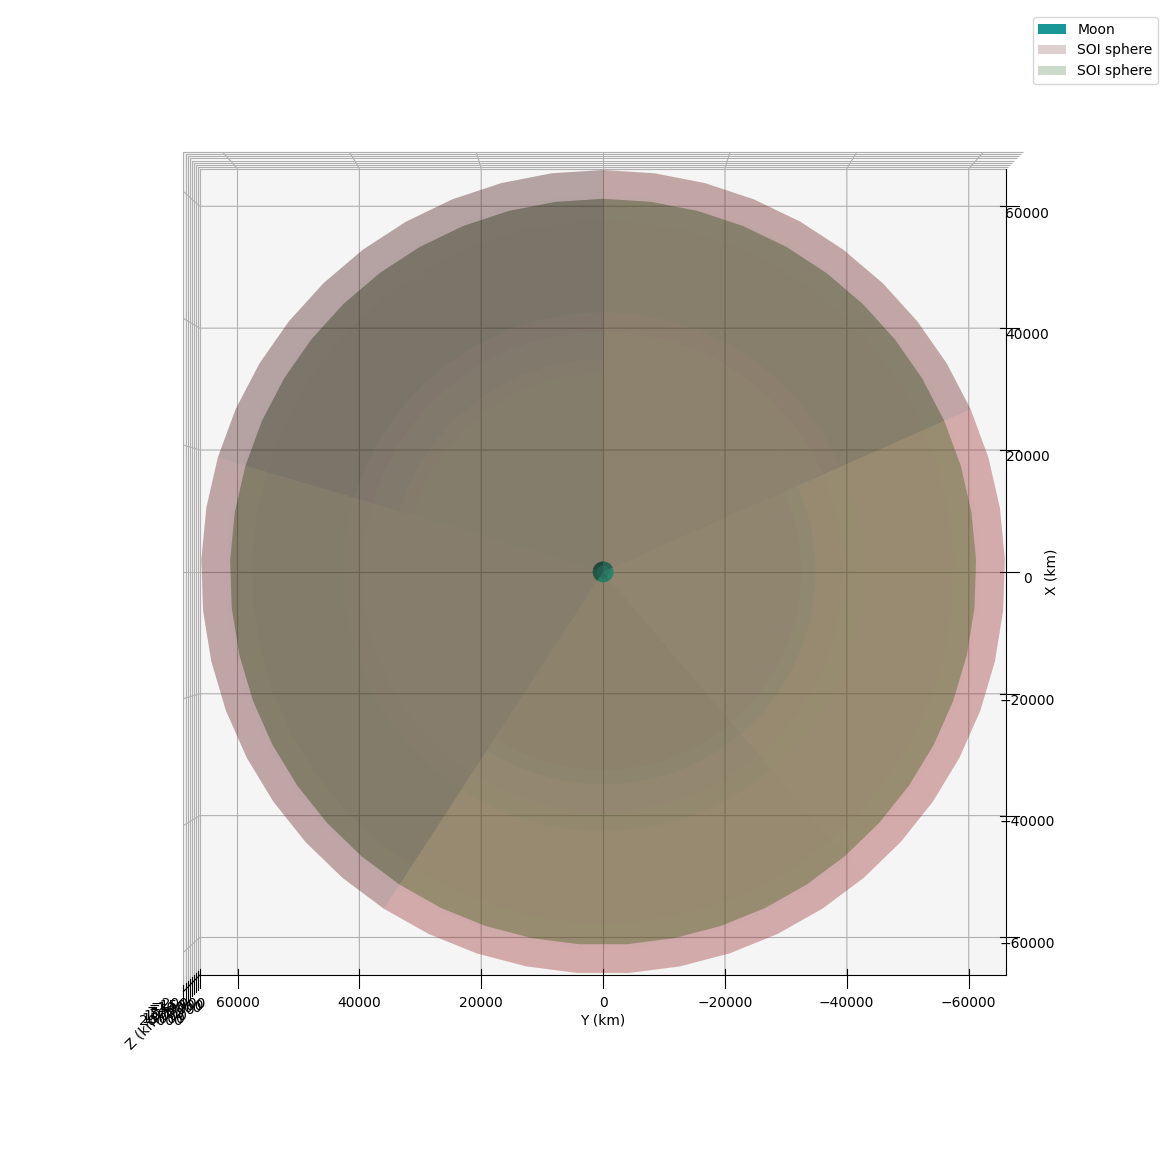

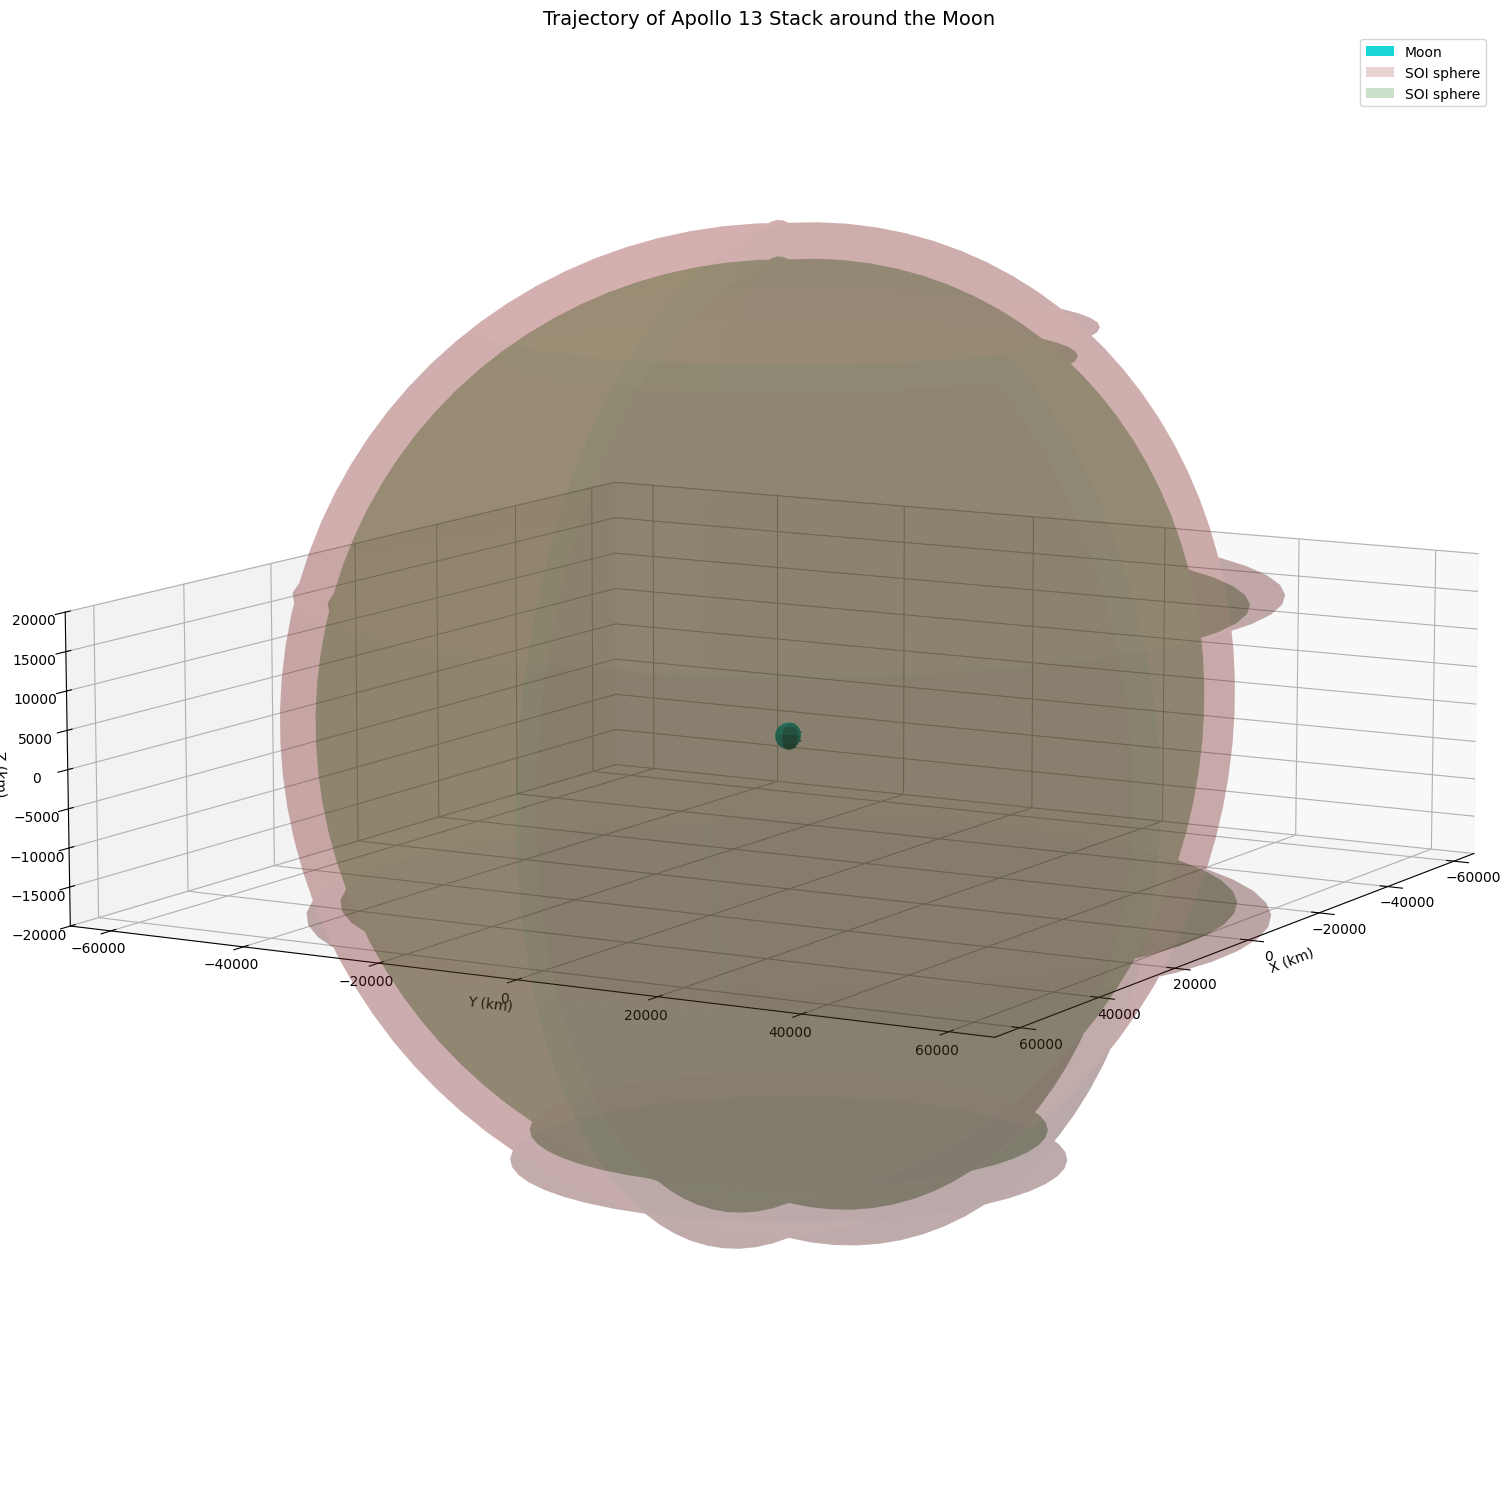

In [1]:
import numpy as np
import matplotlib.pyplot as plt_SOI
import matplotlib.pyplot as plt_stack
import random

# https://svs.gsfc.nasa.gov/4791/

# Gravitational parameter  (mu = GM)
MU_MOON = 4902.8  # km^3/s^2
R_MOON = 1737.4 # km

# keplerian_to_state_vectors function (included for self-containment)
# Adjusted to handle 'a' parameter for different orbit types.
def keplerian_to_state_vectors(a, e, i, raan, arg_of_periapsis, true_anomaly):
    """
    Converts Keplerian orbital elements to orbital state vectors (position and velocity).

    Args:
        a (float): Semi-major axis in kilometers. Positive for elliptical, negative for hyperbolic.
                   For parabolic (e=1), this parameter is internally treated as the periapsis radius
                   for calculating the semilatus rectum 'p'.
        e (float): Eccentricity (dimensionless).
        i (float): Inclination in degrees.
        raan (float): Right Ascension of the Ascending Node in degrees.
        arg_of_periapsis (float): Argument of Periapsis in degrees.
        true_anomaly (float): True Anomaly in degrees.
        mu (float): Gravitational parameter (GM) of the central body in km^3/s^2.

    Returns:
        tuple: A tuple containing:
               - r_vec (np.ndarray): Position vector [x, y, z] in kilometers.
               - v_vec (np.ndarray): Velocity vector [vx, vy, vz] in kilometers/second.
    """

    # Convert angles from degrees to radians
    i_rad = np.radians(i)
    raan_rad = np.radians(raan)
    arg_of_periapsis_rad = np.radians(arg_of_periapsis)
    true_anomaly_rad = np.radians(true_anomaly)
    mu = MU_MOON

    # Calculate semilatus rectum (p)
    # p = a * (1 - e**2) for elliptical and hyperbolic.
    # For parabolic (e=1), p = 2 * r_p, where 'a' is effectively r_p here.
    if abs(e - 1.0) < 1e-9: # Parabolic orbit (e is very close to 1)
        p = 2 * a # For parabolic, 'a' argument is used as periapsis_distance for 'p' calculation.
    else: # Elliptical or Hyperbolic
        p = a * (1 - e**2)

    # Handle cases where 'p' might be extremely small, indicating a degenerate orbit.
    if p < 1e-9 and not (abs(e - 1.0) < 1e-9):
        raise ValueError("Degenerate orbit: Semilatus rectum 'p' is too small for a non-parabolic orbit.")

    # Distance from focus to spacecraft (r_norm)
    # This formula (r = p / (1 + e * cos(nu))) is universal for all conic sections.
    r_norm = p / (1 + e * np.cos(true_anomaly_rad))

    # Position vector in perifocal frame (rp)
    rp_x = r_norm * np.cos(true_anomaly_rad)
    rp_y = r_norm * np.sin(true_anomaly_rad)
    rp_z = 0.0
    rp_vec = np.array([rp_x, rp_y, rp_z])

    # Velocity components in perifocal frame (vp)
    if e < 1e-9: # Circular orbit, simplified velocity
        vp_x = 0.0
        vp_y = np.sqrt(mu / r_norm)
    else: # Elliptical, Parabolic, or Hyperbolic using general formulas
        vp_x = -np.sqrt(mu / p) * e * np.sin(true_anomaly_rad)
        vp_y = np.sqrt(mu / p) * (1 + e * np.cos(true_anomaly_rad))

    vp_z = 0.0
    vp_vec = np.array([vp_x, vp_y, vp_z])

    # 2. Rotation Matrices to transform from perifocal to ECI (Earth-Centered Inertial) frame
    # Rotation around Z-axis by argument of periapsis (w)
    R_w = np.array([
        [np.cos(arg_of_periapsis_rad), -np.sin(arg_of_periapsis_rad), 0],
        [np.sin(arg_of_periapsis_rad), np.cos(arg_of_periapsis_rad), 0],
        [0, 0, 1]
    ])

    # Rotation around X-axis by inclination (i)
    R_i = np.array([
        [1, 0, 0],
        [0, np.cos(i_rad), -np.sin(i_rad)],
        [0, np.sin(i_rad), np.cos(i_rad)]
    ])

    # Rotation around Z-axis by RAAN (Omega)
    R_raan = np.array([
        [np.cos(raan_rad), -np.sin(raan_rad), 0],
        [np.sin(raan_rad), np.cos(raan_rad), 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix: R = R_raan @ R_i @ R_w
    R = R_raan @ R_i @ R_w

    # 3. Transform position and velocity vectors to the ECI frame
    r_vec = R @ rp_vec
    v_vec = R @ vp_vec

    return r_vec, v_vec


def plot_orbit(eccentricity, inclination, arg_of_periapsis, periapsis_distance, raan=0.0, num_points=360):
    """
    Plots an orbit given its Keplerian elements, deriving the semi-major axis from periapsis distance.

    Args:
        eccentricity (float): Eccentricity (dimensionless).
        inclination (float): Inclination in degrees.
        arg_of_periapsis (float): Argument of Periapsis in degrees.
        periapsis_distance (float): Distance at periapsis in kilometers.
        raan (float): Right Ascension of the Ascending Node in degrees (default 0.0).
        mu (float): Gravitational parameter (GM) of the central body in km^3/s^2.
        num_points (int): Number of points to use for plotting the orbit.
        central_body_radius (float): Radius of the central body for visualization (e.g., Earth radius).
    """
    e = eccentricity
    i = inclination
    w = arg_of_periapsis
    rp = periapsis_distance # periapsis distance
    mu = MU_MOON
    central_body_radius = R_MOON

    # Calculate semi-major axis 'a_keplerian' based on orbit type and periapsis distance.
    # This 'a_keplerian' will be passed to keplerian_to_state_vectors.
    if e < 1.0: # Elliptical orbit
        a_keplerian = rp / (1 - e) # Semi-major axis 'a' is positive
        orbit_type = "Elliptical"
        # For elliptical orbits, plot the full 360 degrees
        true_anomalies_deg = np.linspace(0, 360, num_points)
    elif abs(e - 1.0) < 1e-9: # Parabolic orbit (e is very close to 1)
        a_keplerian = rp # For parabolic, 'a' parameter in keplerian_to_state_vectors will be treated as periapsis distance (rp) for 'p' calculation.
        orbit_type = "Parabolic"
        # For parabolic, plot a segment as the orbit extends to infinity.
        # Common range for visualization, avoiding numerical issues near infinity.
        true_anomalies_deg = np.linspace(-150, 150, num_points)
        #print("Note: For parabolic orbit, only a segment is plotted.")
    else: # Hyperbolic orbit (e > 1)
        a_keplerian = -rp / (e - 1) # Semi-major axis 'a' is negative for hyperbolic orbits in standard formulas
        orbit_type = "Hyperbolic"
        # For hyperbolic, the true anomaly 'nu' is limited such that (1 + e*cos(nu)) > 0.
        # This means cos(nu) > -1/e. The maximum true anomaly is acos(-1/e).
        nu_limit_rad = np.arccos(-1/e)
        nu_limit_deg = np.degrees(nu_limit_rad)
        # Plot slightly inside the asymptotes to avoid numerical instability
        true_anomalies_deg = np.linspace(-nu_limit_deg + 5, nu_limit_deg - 5, num_points)
        #print(f"Note: For hyperbolic orbit, true anomaly plotted from {-nu_limit_deg+5:.1f} to {nu_limit_deg-5:.1f} degrees.")

    r_x, r_y, r_z = [], [], []
    v_x, v_y, v_z = [], [], []

    # Calculate position vectors for each true anomaly
    for nu_deg in true_anomalies_deg:
        r_vec, v_vec = keplerian_to_state_vectors(a_keplerian, e, i, raan, w, nu_deg)
        r_x.append(r_vec[0])
        r_y.append(r_vec[1])
        r_z.append(r_vec[2])

        v_x.append(v_vec[0])
        v_y.append(v_vec[1])
        v_z.append(v_vec[2])

    x_module = np.sqrt(np.square(r_x) + np.square(r_y) + np.square(r_z))
    v_module = np.sqrt(np.square(v_x) + np.square(v_y) + np.square(v_z))

    # Plot the central body (e.g., Earth) as a sphere
    u = np.linspace(0, 2 * np.pi, 50) # Azimuthal angle
    v = np.linspace(0, np.pi, 50)     # Polar angle
    x_moon = central_body_radius * np.outer(np.cos(u), np.sin(v))
    y_moon = central_body_radius * np.outer(np.sin(u), np.sin(v))
    z_moon = central_body_radius * np.outer(np.ones(np.size(u)), np.cos(v))

    x_SOI = 66193.29 * np.outer(np.cos(u), np.sin(v))
    y_SOI = 66193.29 * np.outer(np.sin(u), np.sin(v))
    z_SOI = 66193.29 * np.outer(np.ones(np.size(u)), np.cos(v))

    x_HILL = 61532 * np.outer(np.cos(u), np.sin(v))
    y_HILL = 61532 * np.outer(np.sin(u), np.sin(v))
    z_HILL = 61532 * np.outer(np.ones(np.size(u)), np.cos(v))

    angles = [(90, 180, 0), (10, 30, 0)]
    print(f"Plotting position")
    for angle in angles:
        fig = plt_SOI.figure(figsize=(20,15))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev = angle[0], azim = angle[1], roll = angle[2])
        #ax.plot(r_x, r_y, r_z, label='Apollo Stack', color='red') # do not plot orbit
        ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, label='Moon', color='cyan')
        ax.plot_surface(x_SOI, y_SOI, z_SOI,  cstride=10, alpha=0.2, label='SOI sphere', color='brown')
        ax.plot_surface(x_HILL, y_HILL, z_HILL,  cstride=10, alpha=0.2, label='SOI sphere', color='green')

        ax.set_xlim([-66193.29, 66193.29])
        ax.set_ylim([-66193.29, 66193.29])
        ax.set_zlim([-20000, 20000])

        ax.set_xlabel('X (km)')
        ax.set_ylabel('Y (km)')
        ax.set_zlabel('Z (km)')
        ax.legend()
        ax.set_aspect('equal', adjustable='box') # 'equal' ensures correct proportions
        plt_SOI.grid(True)

    plt_SOI.title('Trajectory of Apollo 13 Stack around the Moon', fontsize = '14')
    plt_SOI.tight_layout()
    plt_SOI.show()

    max_v = np.max(v_module)
    min_v = np.min(v_module)
    max_x = np.max(x_module)
    min_x = np.min(x_module)
    plt_stack.show()

if __name__ == "__main__":
    # Example 1: Elliptical Earth Orbit (LEO-like)
    print("--- Plotting Elliptical Orbit ---")
    plot_orbit(
        eccentricity=1.4462,
        inclination=173.7,
        arg_of_periapsis=28.7,
        periapsis_distance=(136 + R_MOON), # Altitude  (Moon Radius 1737 km + 136 km)
        raan=-150.74
    )

Orbital parameters:
Eccentricity: 1.446, Perifocal Distance: 1988.800 km, Inclination: 173.700, Argument of Periapsis: 28.700, Longitude of the Ascending Node: -150.740
Semi-major axis hyperbola: -4457.194 km Radius Moon: 1737.400 km
-6690.61  -251.4
Maximum velocity: 2.46 km/s   8057.74 ft/s
Pericynthius: 251.40 km
251.4  6690.61


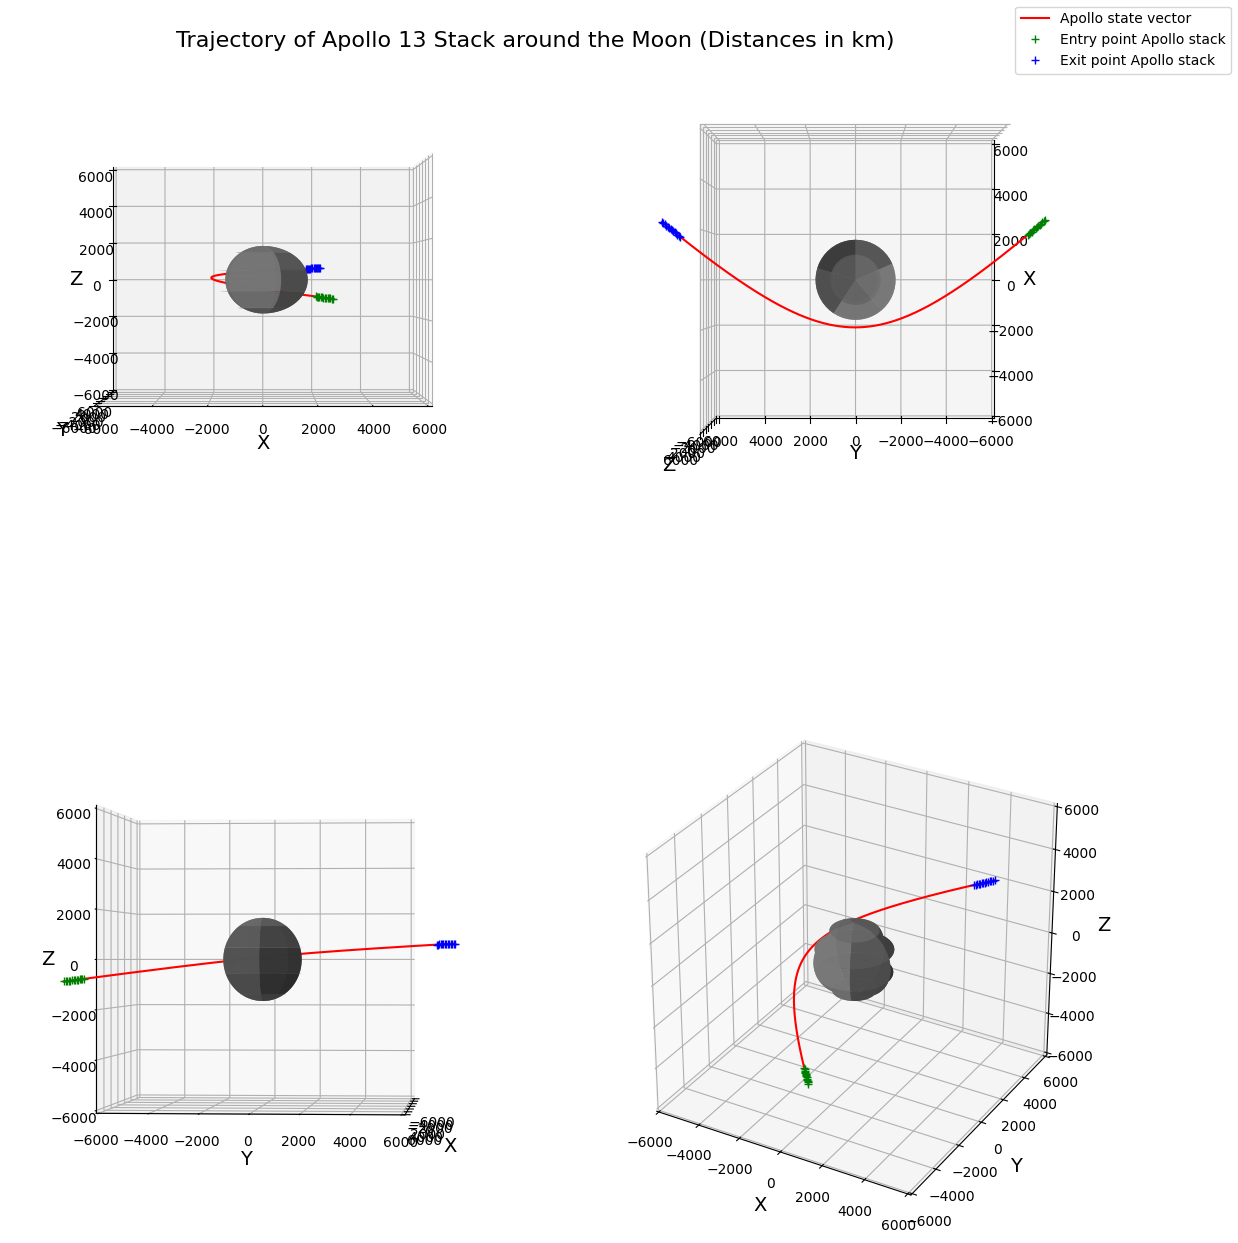

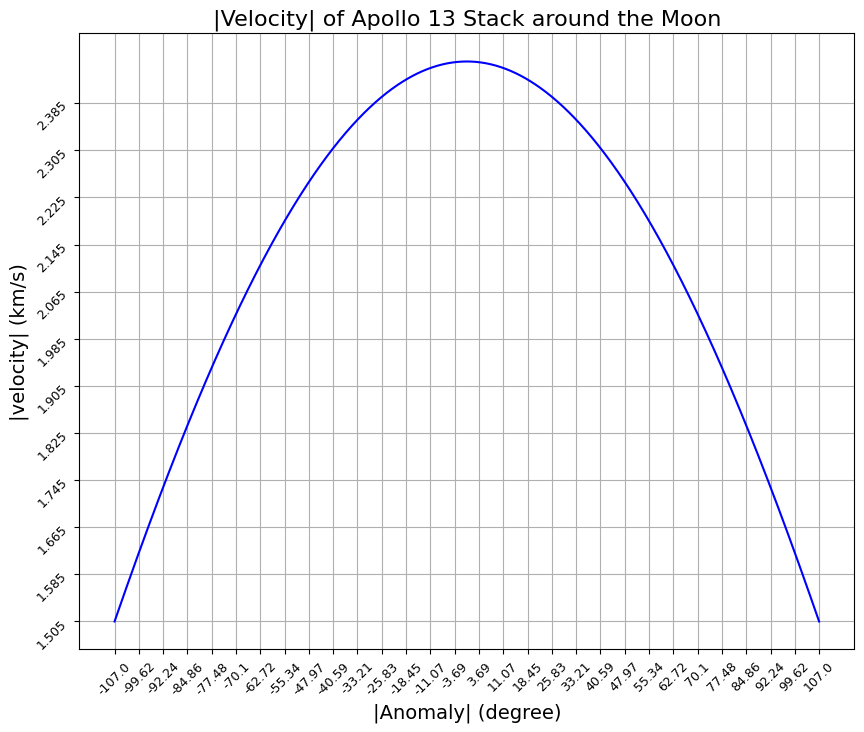

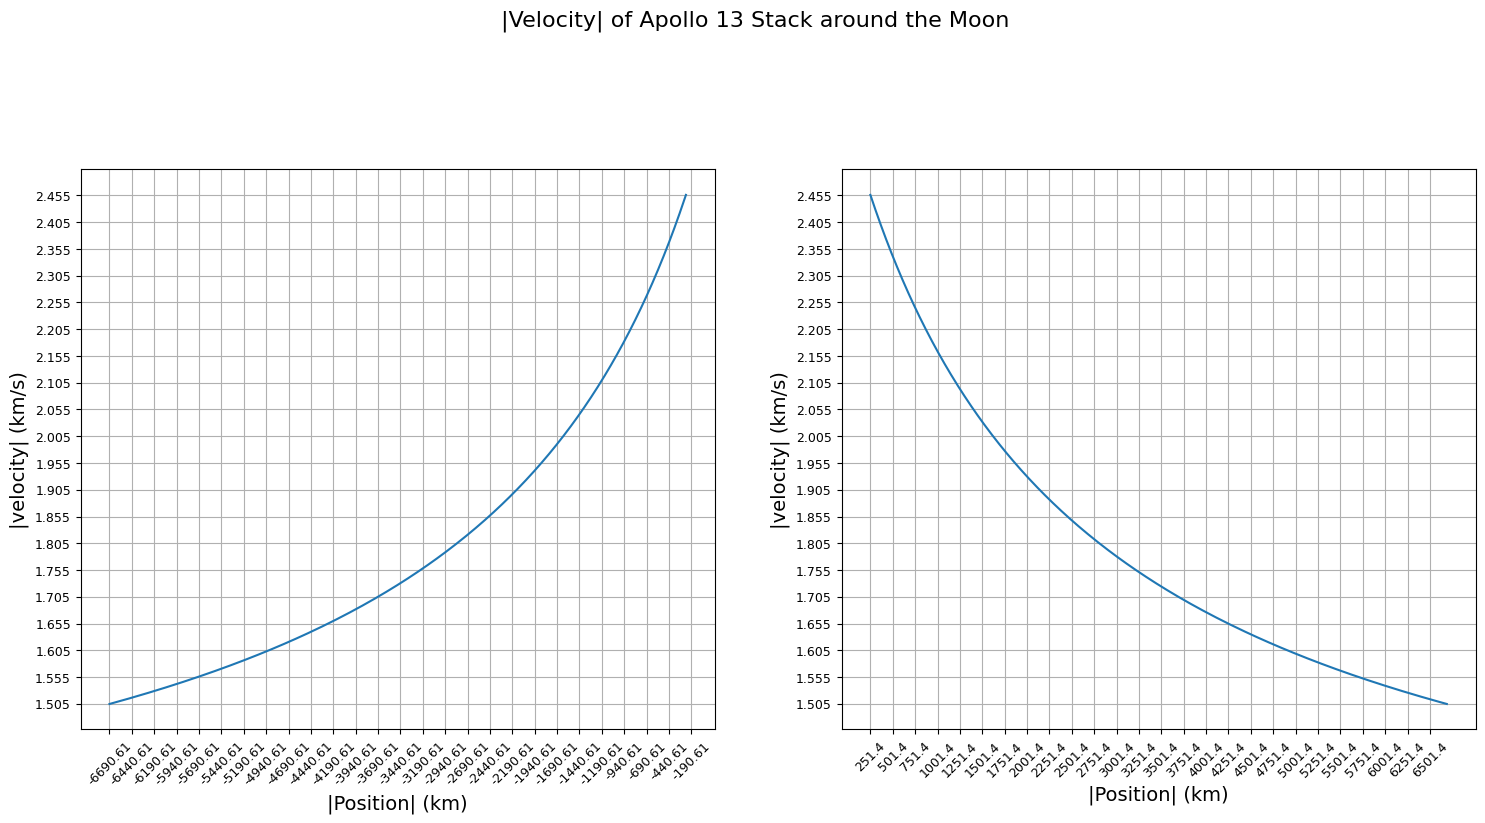

In [38]:
# ref data https://svs.gsfc.nasa.gov/4791/#photos
# get startedpyorb  https://danielk.developer.irf.se/pyorb/notebooks/getting_started_tutorial.html

import matplotlib.pyplot as plt_3d_stack
import matplotlib.pyplot as plt_2d_stack
import matplotlib.pyplot as plt_velocity
import numpy as np
import pyorb

num = 1000

R_MOON = 1737.4 # km
ecc = 1.4462
_p = 1988.8
_a = _p / (ecc - 1.0)
_i = 173.7
_omega = 28.7
theta_inf = pyorb.kepler.true_of_the_asymptote(e=ecc, degrees=True)
theta_inf *= 0.8
_Omega = -150.74

print (f'Orbital parameters:')
print (f'Eccentricity: {ecc:.3f}, Perifocal Distance: {_p:.3f} km, Inclination: {_i:.3f}, Argument of Periapsis: {_omega:.3f}, Longitude of the Ascending Node: {_Omega:.3f}')
print (f'Semi-major axis hyperbola: -{_a:.3f} km Radius Moon: {R_MOON:.3f} km')
orb = pyorb.Orbit(
    M0 = 7.34767309e22, # kg
    G = pyorb.get_G(length='km', mass='kg', time='s'),
    a = _a,
    e = ecc,
    i = _i,
    omega = _omega,
    Omega = _Omega,
    anom = np.linspace(-theta_inf, theta_inf, num=num),
    degrees = True,
    num = num,
    type = 'true',
)

r = orb.r
v = orb.v

legend_label = ['Apollo state vector', "Entry point Apollo stack", "Exit point Apollo stack"]
fig = plt_3d_stack.figure(figsize=(14, 14))
ax = fig.add_subplot(221, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
u_sphere = np.linspace(0, 2 * np.pi, 50) # Azimuthal angle
v_sphere = np.linspace(0, np.pi, 50)     # Polar angle
x_moon = R_MOON * np.outer(np.cos(u_sphere), np.sin(v_sphere))
y_moon = R_MOON * np.outer(np.sin(u_sphere), np.sin(v_sphere))
z_moon = R_MOON * np.outer(np.ones(np.size(u_sphere)), np.cos(v_sphere))
enter_limit_point = int(num/70)
exit_limit_point = r.shape[1] - enter_limit_point
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, label='Moon', color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
xyzlim = np.array([ax.get_xlim3d(),ax.get_ylim3d(),ax.get_zlim3d()]).T
XYZlim = [min(xyzlim[0])/3*2, max(xyzlim[1])/3*2]
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)

ax.view_init(0, -90, 0)
ax = fig.add_subplot(222, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect('equal', 'box')

ax.view_init(90, 180, 0)
ax = fig.add_subplot(223, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect('equal', 'box')

ax.view_init(0, 5, 0)
ax = fig.add_subplot(224, projection='3d')
ax.plot(r[0, :], r[1, :], r[2, :], '-r')
ax.plot(r[0, 0:enter_limit_point], r[1, 0:enter_limit_point], r[2, 0:enter_limit_point], '+g')
ax.plot(r[0, exit_limit_point:], r[1, exit_limit_point:], r[2, exit_limit_point:], '+b')
ax.plot_surface(x_moon, y_moon, z_moon,  cstride=10, alpha=0.9, color='grey')
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim)
ax.set_aspect('equal')
fig.suptitle('Trajectory of Apollo 13 Stack around the Moon (Distances in km)', fontsize = '16')
fig.subplots_adjust(top=1)
fig.legend(legend_label, fontsize = '10')
#plt_3d_stack.show()
plt_3d_stack.savefig('Apollo_13_Stack_around_Moon.png')

k_x = np.sqrt(np.square(r[0, :]) + np.square(r[1, :]) + np.square(r[2, :]))
pericynthium = min(k_x) - R_MOON
k_x [np.where(k_x < 0)] += R_MOON
k_x [np.where(k_x >= 0)] -= R_MOON

# plot velocity vs mean anomaly

fig_, ax = plt_2d_stack.subplots(figsize=(10, 8))
anomaly_Xticks = np.linspace(round (min (orb.true_anomaly), 2), round (max (orb.true_anomaly), 2), 30)
anomaly_Xticks = np.round(anomaly_Xticks, 2)
listOf_Yticks = np.arange(min (orb.velocity), max(orb.velocity), step = 0.080)
listOf_Yticks = np.round(listOf_Yticks, 3)
plt_2d_stack.yticks(listOf_Yticks, listOf_Yticks, fontsize='9', rotation=45)
plt_2d_stack.xticks(anomaly_Xticks, anomaly_Xticks, fontsize='9', rotation=45)
plt_2d_stack.plot(orb.true_anomaly, orb.velocity, '-b')
ax.set_xlabel('|Anomaly| (degree)', fontsize = '14')
ax.set_ylabel('|velocity| (km/s)', fontsize = '14')
ax.set_title(f'|Velocity| of Apollo 13 Stack around the Moon', fontsize = '16')
ax.grid(True)
#plt_2d_stack.show()
plt_2d_stack.savefig('Apollo_13_Stack_anomaly_velocity_around_Moon.png')

# plot velocity vs distance

index=int(len(k_x)/2)
a = [-element for element in k_x[0:index]]

fig = plt_velocity.figure(figsize=(18, 16))
ax = fig.add_subplot(221)
ax.set_ylabel('|velocity| (km/s)', fontsize = '14')
ax.set_xlabel('|Position| (km)', fontsize = '14')
print(f"{-round(max(k_x), 2)}  {-round(min(k_x), 2)}")
#listOf_Xticks = np.arange(-round(max(k_x), 2), -round(min(k_x), 2), step = 250)
listOf_Xticks = np.arange(-round(max(k_x), 2), -20, step = 250)
listOf_Xticks = np.round(listOf_Xticks, 3)
listOf_Yticks = np.arange(min (orb.velocity[index:len(k_x)]), max(orb.velocity[index:len(k_x)]), step = 0.05)
listOf_Yticks = np.round(listOf_Yticks, 3)
plt_velocity.xticks(listOf_Xticks, listOf_Xticks, fontsize='9', rotation=45)
plt_velocity.yticks(listOf_Yticks, listOf_Yticks, fontsize='9')
ax.plot(a, orb.velocity[0:index])
ax.grid(True)

print (f"Maximum velocity: {max(orb.velocity):.2f} km/s   {(max(orb.velocity) * 3280.84):.2f} ft/s")
print (f"Pericynthius: {(pericynthium):.2f} km")

ax = fig.add_subplot(222)
a = np. array(k_x[index:len(k_x)])
ax.set_ylabel('|velocity| (km/s)', fontsize = '14')
ax.set_xlabel('|Position| (km)', fontsize = '14')
ax.plot(a, orb.velocity[index:len(k_x)])
print(f"{round(min(k_x), 2)}  {round(max(k_x), 2)}")
listOf_Xticks = np.arange(round(min(k_x), 2), round(max(k_x), 2), step = 250)
listOf_Xticks = np.round(listOf_Xticks, 3)
plt_velocity.xticks(listOf_Xticks, listOf_Xticks, fontsize='9', rotation=45)
plt_velocity.yticks(listOf_Yticks, listOf_Yticks, fontsize='9')

ax.grid(True)
fig.suptitle(f'|Velocity| of Apollo 13 Stack around the Moon', fontsize = '16')
plt_velocity.savefig('Apollo_13_Stack_state_vector_around_Moon.png')


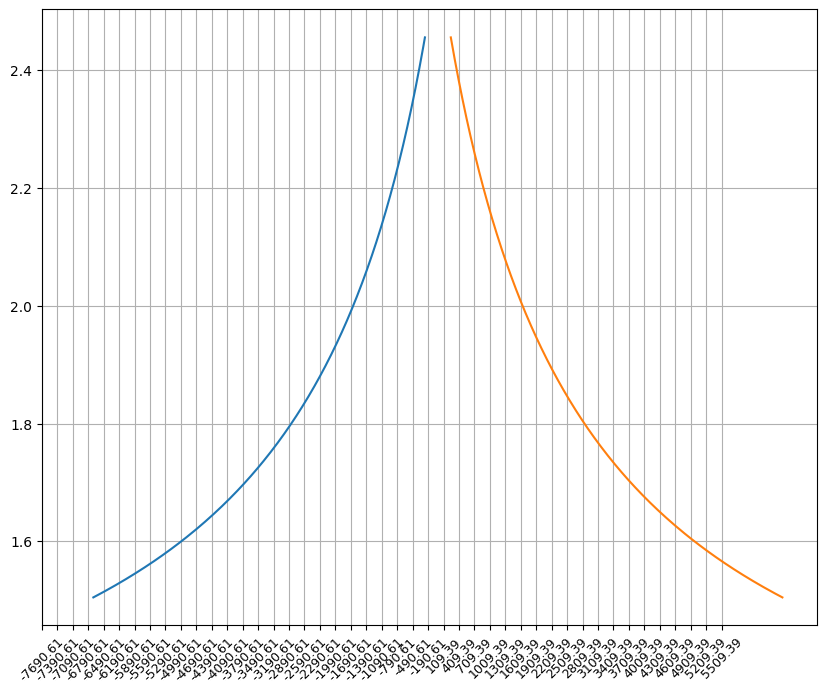

In [113]:

import matplotlib.pyplot as plt2
xs_list = list(k_x)

index=int(len(xs_list)/2)
a = np. array(xs_list[0:index])
a = [-element for element in xs_list[0:index]]

ax = fig.add_subplot(211)
fig_, ax = plt_3d_stack.subplots(figsize=(10, 8))
plt2.plot(a, orb.velocity[0:index])
a = np. array(xs_list[index:len(k_x)])
plt2.plot(a, orb.velocity[index:len(k_x)])

listOf_Xticks = np.arange(-round(max(k_x) + 1000, 2), round(max(k_x), 2) - 1000, step = 300)
listOf_Xticks = np.round(listOf_Xticks, 3)
plt_velocity.xticks(listOf_Xticks, listOf_Xticks, fontsize='9', rotation=45)

plt2.grid(True)
plt2.show()